In [1]:
import glob
import re
import json 
import functools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rc('font', size=12, family='Arial')

In [2]:
with open('../../pair_counts.json') as f:
    read_pairs = json.load(f)
million_mapped = {k: v/2e6 for k, v in read_pairs.items()}

In [3]:
with open('../../mean_spikein_counts.json', 'r') as f:
    mean_spike_counts = json.load(f)

In [4]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str).str.cat(df.strand.astype(str), sep=';'), sep='-'), sep=':')


In [5]:
def get_max_depths(file_path, extension='.cov'):
    files = glob.glob(f'{file_path}*{extension}')
    data = {
    re.findall('([^/]+).([mp]).cov', f)[0]: 
        pd.read_csv(f, names =('chr', 'start', 'end', 'name', 'value', 'strand', 'max_coverage'), sep='\t')
    for f in files
    }
    p_data = {
    'chr': list(data.values())[0].chr,
    'start': list(data.values())[0].start,
    'end': list(data.values())[0].end,
    'strand': list(data.values())[0].strand
    }

    m_data = {
        'chr': list(data.values())[0].chr,
        'start': list(data.values())[0].start,
        'end': list(data.values())[0].end,
        'strand': list(data.values())[0].strand
    }

    for sample_name, counts in data.items():
        if sample_name[1] == 'p':
            p_data[sample_name[0]] = pd.to_numeric(counts['max_coverage'], errors='coerce')
        if sample_name[1] == 'm':
            m_data[sample_name[0]] = pd.to_numeric(counts['max_coverage'], errors='coerce') 
    p_data = pd.DataFrame(p_data)
    m_data = pd.DataFrame(m_data)
    sense = m_data.copy()
    sense[sense.strand == '-'] = p_data[sense.strand == '-']
    antisense = p_data.copy()
    antisense[antisense.strand == '-'] = m_data[antisense.strand == '-']
    sense['ucsc_name']= ucsc_index(sense)
    antisense['ucsc_name']= ucsc_index(antisense)
    return sense, antisense

In [6]:
sense, antisense = get_max_depths('../../max_read_depths/gl3_peaks/')
sense_genes, antisense_genes = get_max_depths('../../max_read_depths/genes/')

In [7]:
common_cols = set(sense.columns) & mean_spike_counts.keys()

In [8]:
norm_sense = sense.copy()

In [9]:
copy_number = pd.read_csv('../../max_read_depths/peak_copy_numbers.bed', sep='\t', 
                          names = 'chr start end name value strand copy_number'.split()
                         )
copy_number['ucsc_name'] = ucsc_index(copy_number)
norm_sense.loc[:, common_cols] = norm_sense.loc[:, common_cols] / pd.Series(mean_spike_counts)[common_cols]
norm_sense = norm_sense.merge(copy_number[['ucsc_name', 'copy_number']], how='left')
norm_sense = norm_sense[norm_sense.copy_number > 0]

In [10]:
for i in common_cols:
    norm_sense.loc[:, i] = 3.76 *(norm_sense.loc[:, i]/norm_sense.copy_number)

In [11]:
sorted_norm_sense = norm_sense.iloc[norm_sense[['dmso_2', 'dmso_3', 'drb_2', 'drb_3', 'gl3_2', 'gl3_3']].mean(axis=1).argsort()[::-1], :]

In [12]:
sorted_norm_sense[sorted_norm_sense.ucsc_name == 'chr7:12390967-12391360;+']

,chr,dmso_2,dmso_3,dmso_in,drb_2,drb_3,drb_in,drb_rh,end,gl3_2,gl3_3,gl3_in,gl3_rh,start,strand,ucsc_name,copy_number
14040,chr7,NaN,NaN,0.256364,0.000294,0.000326,4.0,0.007581,12391360,NaN,NaN,0.313333,0.005562,12390967,+,chr7:12390967-12391360;+,4.0


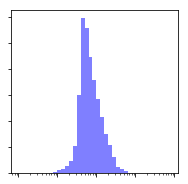

In [13]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(((sorted_norm_sense.gl3_2 + sorted_norm_sense.gl3_3)/2).dropna(), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color='blue')

ax.set_xscale('log')
ax.set_xticklabels('')
ax.set_yticklabels('')
fig.savefig('Unannotated_gl3_fractions.svg')

In [14]:
1/((sorted_norm_sense.gl3_2 + sorted_norm_sense.gl3_3)/2).dropna().mean()

114.56680733513483

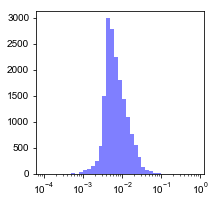

In [15]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(((sorted_norm_sense.gl3_2 + sorted_norm_sense.gl3_3)/2).dropna(), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color='blue')

ax.set_xscale('log')
fig.savefig('Annotated_gl3_fractions.png')

Text(0.5,0,'Approx allelic fraction')

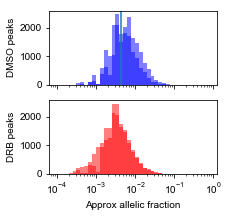

In [16]:
fig, ax = plt.subplots(nrows=2,sharex=True, sharey=True, figsize=(3,3))

ax[0].hist((sorted_norm_sense.dmso_3.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color='blue')
ax[0].hist((sorted_norm_sense.dmso_2.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color='blue')
ax[0].axvline(x=0.00443)
ax[1].hist((sorted_norm_sense.drb_2.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color = 'red')
ax[1].hist((sorted_norm_sense.drb_3.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color = 'red')


for a in ax:
    a.set_xscale('log')

ax[0].set_ylabel('DMSO peaks')
ax[1].set_ylabel('DRB peaks')
ax[1].set_xlabel('Approx allelic fraction')
#fig.tight_layout()

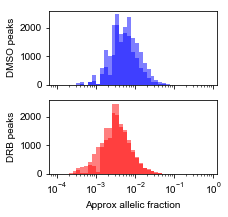

In [17]:
fig, ax = plt.subplots(nrows=2,sharex=True, sharey=True, figsize=(3,3))

ax[0].hist((sorted_norm_sense.dmso_3.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color='blue')
ax[0].hist((sorted_norm_sense.dmso_2.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color='blue')

ax[1].hist((sorted_norm_sense.drb_2.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color = 'red')
ax[1].hist((sorted_norm_sense.drb_3.dropna()), 
        bins = 10 ** np.arange(-4,  0, 0.1), 
        alpha=0.5, color = 'red')


for a in ax:
    a.set_xscale('log')

ax[0].set_ylabel('DMSO peaks')
ax[1].set_ylabel('DRB peaks')
ax[1].set_xlabel('Approx allelic fraction')
#fig.tight_layout()
fig.savefig('Allelic_fraction.svg')

In [18]:
gene_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_GENCODE_v29_symbols.tsv', sep='\t',
                        names = ('transcript_id', 'symbol', 'gencode_2', 'chr', 'strand', 'start', 'end', 
                                 'cd_start', 'cd_end', 'exon_count', 'exon_starts', 'exon_ends', 'prot_id', 'align_id'),
                        usecols = ('chr', 'start', 'end', 'strand', 'symbol', 'align_id', 'transcript_id'), header = 0
                       )

In [19]:
gene_data['ucsc_name'] = ucsc_index(gene_data)

In [20]:
gene_data.head()

,transcript_id,symbol,chr,strand,start,end,align_id,ucsc_name
0,ENST00000367772.8,SCYL3,chr1,-,169853073,169893959,uc001ggs.5,chr1:169853073-169893959;-
1,ENST00000359326.8,C1orf112,chr1,+,169795048,169854080,uc001ggp.4,chr1:169795048-169854080;+
2,ENST00000374005.7,FGR,chr1,-,27612063,27635277,uc001bom.4,chr1:27612063-27635277;-
3,ENST00000367429.8,CFH,chr1,+,196651877,196747504,uc001gtj.4,chr1:196651877-196747504;+
4,ENST00000003583.12,STPG1,chr1,-,24357004,24413725,uc001bja.4,chr1:24357004-24413725;-


In [21]:
overlaps = pd.read_csv('../../peak_calls/combined_bam_peaks/gene_overlap/gl3_ovelap.tsv', 
                       names = 'chr start end name value strand gene_chr gene_start gene_end transcript_id overlap'.split(),
                       usecols = 'chr start end strand transcript_id'.split(), sep='\t'
                      )


In [22]:
overlaps['ucsc_name'] = ucsc_index(overlaps)

In [23]:
with_symbols = sorted_norm_sense.merge(overlaps[['transcript_id', 'ucsc_name']], how = 'left').merge(gene_data[['transcript_id', 'symbol']], how='left')

In [24]:
with_symbols.head(20)

,chr,dmso_2,dmso_3,dmso_in,drb_2,drb_3,drb_in,drb_rh,end,gl3_2,gl3_3,gl3_in,gl3_rh,start,strand,ucsc_name,copy_number,transcript_id,symbol
0,chr6,0.177527,0.131990,1.919441,0.097180,0.118927,46.0,0.228586,157323465,0.165344,0.137515,3.470769,0.328594,157310368,-,chr6:157310368-157323465;-,13.0,ENST00000603032.1,AL390955.2
1,chr6,0.177527,0.131990,1.919441,0.097180,0.118927,46.0,0.228586,157323465,0.165344,0.137515,3.470769,0.328594,157310368,-,chr6:157310368-157323465;-,13.0,ENST00000400788.8,TMEM242
2,chr19,0.085765,0.066706,0.683636,0.071821,0.067248,5.0,0.272903,3985487,0.130810,0.070049,1.566667,0.589586,3974449,-,chr19:3974449-3985487;-,2.0,ENST00000384048.1,SNORD37
3,chr19,0.085765,0.066706,0.683636,0.071821,0.067248,5.0,0.272903,3985487,0.130810,0.070049,1.566667,0.589586,3974449,-,chr19:3974449-3985487;-,2.0,ENST00000309311.6,EEF2
4,chr8,0.099409,0.060432,2.990909,0.070938,0.077694,27.0,1.334194,127229303,0.095230,0.075521,3.603333,0.862130,127187733,-,chr8:127187733-127229303;-,4.0,.,NaN
5,chr5,0.088201,0.052837,0.512727,0.072704,0.071492,7.0,0.424516,171419233,0.106218,0.068954,0.940000,1.145799,171387702,+,chr5:171387702-171419233;+,4.0,ENST00000517671.5,NPM1
6,chr5,0.088201,0.052837,0.512727,0.072704,0.071492,7.0,0.424516,171419233,0.106218,0.068954,0.940000,1.145799,171387702,+,chr5:171387702-171419233;+,4.0,ENST00000274625.5,FGF18
7,chr7,0.075369,0.062524,0.569697,0.039639,0.028292,5.0,0.090968,44806213,0.130461,0.085615,1.462222,0.222485,44796510,+,chr7:44796510-44806213;+,3.0,ENST00000468812.5,PPIA
8,chr11,0.071633,0.056800,0.512727,0.052100,0.062351,7.0,0.955161,65450484,0.091044,0.078075,0.940000,2.119172,65421722,+,chr11:65421722-65450484;+,4.0,ENST00000620348.1,RF01955
9,chr11,0.071633,0.056800,0.512727,0.052100,0.062351,7.0,0.955161,65450484,0.091044,0.078075,0.940000,2.119172,65421722,+,chr11:65421722-65450484;+,4.0,ENST00000620525.1,RF01956


In [25]:
with_symbols.loc[with_symbols.symbol == 'TMEM242', ['dmso_2', 'dmso_3']].mean(axis=1)

1       0.154759
2983    0.014212
dtype: float64

In [26]:
with_symbols.loc[with_symbols.symbol == 'ACTB', ['dmso_2', 'dmso_3']].mean(axis=1)

158    0.040963
dtype: float64

In [27]:
with_symbols.loc[with_symbols.symbol == 'MYC', ['gl3_2', 'gl3_3']].mean(axis=1)

551    0.029935
dtype: float64

In [28]:
with_symbols.loc[with_symbols.symbol == 'RPL13A', ['gl3_2', 'gl3_3']].mean(axis=1)

88    0.057663
dtype: float64

In [29]:
with_symbols.loc[with_symbols.symbol == 'NEAT1', ['gl3_2', 'gl3_3']].mean(axis=1)

11    0.084559
dtype: float64

In [30]:
with_symbols.loc[with_symbols.symbol == 'RPL37', ['gl3_2', 'gl3_3']].mean(axis=1)

54    0.063231
dtype: float64

In [31]:
with_symbols.loc[with_symbols.symbol == 'MLKL', ['gl3_2', 'gl3_3']].mean(axis=1)

Series([], dtype: float64)

In [32]:
with_symbols.loc[with_symbols.symbol == 'ZNF544', ['gl3_2', 'gl3_3']].mean(axis=1)

Series([], dtype: float64)

In [33]:
repeat_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/repeats/hg38_all_rna_repeats.tsv',
                           sep = '\t', 
                          skiprows=1,
                         )
                         

In [34]:
new_names = {'genoName':'chr', 'genoStart':'start', 'genoEnd':'end'}
repeat_data = repeat_data[['genoName', 'genoStart', 'genoEnd', 'strand', 'repName', 'repClass', 'repFamily']].rename(columns=new_names)

In [35]:
repeat_data['ucsc_name'] = ucsc_index(repeat_data)

In [36]:
sense_reps = sense_reps.merge(repeat_data[['ucsc_name', 'repName']], on=['ucsc_name'], how ='left')

NameError: name 'sense_reps' is not defined

In [37]:
sense_reps.dropna().sort_values('gl3_2', ascending=False)

NameError: name 'sense_reps' is not defined

In [38]:
sense_reps.iloc[sense_reps[['dmso_2', 'dmso_3', 'drb_2', 'drb_3', 'gl3_2', 'gl3_3']].mean(axis=1).argsort()[::-1], :].dropna()

NameError: name 'sense_reps' is not defined

In [37]:
sorted_norm_sense.loc[14040, :]

chr                                chr7
dmso_2                              NaN
dmso_3                              NaN
dmso_in                        0.256364
drb_2                       0.000294348
drb_3                       0.000326446
drb_in                                4
drb_rh                       0.00758065
end                            12391360
gl3_2                               NaN
gl3_3                               NaN
gl3_in                         0.313333
gl3_rh                       0.00556213
start                          12390967
strand                                +
ucsc_name      chr7:12390967-12391360;+
copy_number                           4
Name: 14040, dtype: object

In [38]:
1/(sorted_norm_sense.loc[:, ['gl3_2', 'gl3_3']].mean(axis=1).dropna()[1:].median())

158.23421365204783

In [39]:
1/(sorted_norm_sense.loc[:, ['drb_2', 'drb_3']].mean(axis=1).dropna()[1:].median())

301.05994199911214

In [40]:
1/(sorted_norm_sense.loc[:, ['dmso_2', 'dmso_3']].mean(axis=1).dropna()[1:].median())

188.18428623595508

In [41]:
probs = sorted_norm_sense.loc[:, ['gl3_2', 'gl3_3']].mean(axis=1).dropna()[1:]

In [42]:
len(probs)

16884

In [43]:
test_matrix = np.zeros((len(probs), 20000))

In [44]:
for i in range(len(probs)):
    if not i % 100:
        print(i / len(probs))
    test_matrix[i, :] = (np.random.random(test_matrix.shape[1]) < probs.iloc[i])

0.0
0.005922767116796968
0.011845534233593935
0.017768301350390904
0.02369106846718787
0.029613835583984838
0.03553660270078181
0.04145936981757877
0.04738213693437574
0.053304904051172705
0.059227671167969675
0.06515043828476665
0.07107320540156362
0.07699597251836057
0.08291873963515754
0.08884150675195451
0.09476427386875148
0.10068704098554845
0.10660980810234541
0.11253257521914238
0.11845534233593935
0.12437810945273632
0.1303008765695333
0.13622364368633025
0.14214641080312723
0.1480691779199242
0.15399194503672115
0.15991471215351813
0.16583747927031509
0.17176024638711207
0.17768301350390903
0.18360578062070598
0.18952854773750297
0.19545131485429992
0.2013740819710969
0.20729684908789386
0.21321961620469082
0.2191423833214878
0.22506515043828476
0.23098791755508175
0.2369106846718787
0.24283345178867566
0.24875621890547264
0.2546789860222696
0.2606017531390666
0.26652452025586354
0.2724472873726605
0.27837005448945745
0.28429282160625446
0.2902155887230514
0.2961383558398484


In [45]:
min(test_matrix.sum(axis=0))

101.0

In [46]:
test_matrix.sum(axis=0).mean()

146.9709

In [47]:
max(test_matrix.sum(axis=0))

197.0

In [48]:
test_matrix = test_matrix.T

In [49]:
total_counts = allele_counts.sum(axis=1)

NameError: name 'allele_counts' is not defined

In [50]:
((total_counts < 300) & (total_counts >= 280)).mean()

NameError: name 'total_counts' is not defined

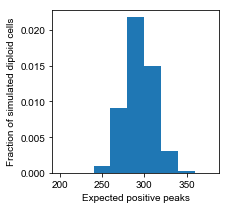

In [51]:
fig, ax = plt.subplots(figsize=(3, 3))
allele_counts = test_matrix[(len(test_matrix)//2):, :] + test_matrix[:len(test_matrix)//2, :]
ax.hist(allele_counts.sum(axis=1), normed=True, bins = np.arange(200,400,20))
ax.set_xlabel('Expected positive peaks')
ax.set_ylabel('Fraction of simulated diploid cells')
fig.savefig('Simulated-R-Loop-Counts.svg')

In [55]:
np.histogram(allele_counts.sum(axis=1), bins = np.arange(200,400,20))

(array([   0,    1,  188, 1804, 4343, 2997,  620,   47,    0]),
 array([200, 220, 240, 260, 280, 300, 320, 340, 360, 380]))

In [56]:
len(allele_counts)

10000

In [214]:
np.mean(allele_counts.sum(axis=1))

294.13429

In [215]:
np.std(allele_counts.sum(axis=1))

17.042184020714597

In [213]:
np.percentile(allele_counts.sum(axis=1), 2.5), np.percentile(allele_counts.sum(axis=1), 97.5)

(261.0, 328.0)

In [258]:
test_matrix.mean(axis=0)

array([0.0096612 , 0.01001093, 0.00939891, ..., 0.00935519, 0.00900546,
       0.0090929 ])

In [244]:
np.random.random((100000))

array([0.93789791, 0.3246606 , 0.98181779, ..., 0.77410987, 0.17887379,
       0.40856849])

In [247]:
test_matrix[4, :].sum()

733.0